# * Business Growth Overview *

## Note :

### Compare with VINSIGHT overview : 
- Total Revenue data about 2 days late.
- Target is lower than VINSIGHT (include "TDG" ?)
- %MoM, %WoW is different from VINSIGHT

## Import Data Source
Monitoring Job : 9.00 / 14.00 / 18.00 / 22.00

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
# import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

##### *** "TDG Revenue (Performance View)" or "TDG Revenue (Conso View)" ? : 
- AGG_TYPE = N

In [2]:
''' Config '''

config = configparser.ConfigParser()
config.read('../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']

In [3]:
data_src = f"../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD list '''
prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00143'] # include "TDG Revenue (Conso View)"
# tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list
# bg_rev_sum_cd_list = ['DB1R000100', 'TB1R000100', 'DB2R000100', 'TB2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # Exclude : Total of PRE & POST
# bg_rev_sum_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

''' Fix Agg Column Name(Total Revenue) '''
bg_col_list = ['POST_DTAC', 'POST_TMH', 'PRE_DTAC', 'PRE_TMH', 'TOL', 'TVS']

In [4]:
df.shape

(64778, 13)

In [5]:
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

In [6]:
df[['METRIC_CD', 'METRIC_NAME']].drop_duplicates()

,METRIC_CD,METRIC_NAME
33971,B2R000100,Postpaid Revenue
34160,DB2R000100,Postpaid Revenue : DTAC
34349,TB2R000100,Postpaid Revenue : TMH
44744,B1R000100,Prepaid Revenue
44933,DB1R000100,Prepaid Revenue : DTAC
45122,TB1R000100,Prepaid Revenue : TMH
54005,TB3R000100,TOL Revenue
59675,TB4R000100,TVS Revenue


In [7]:
''' Find Metric '''

# df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric

# df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # df_tmp.to_excel('Prepaid_Metric.xlsx')
# df_tmp

KeyError: 'CENTER'

## Data Preporation

In [ ]:
''' Function '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

In [ ]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202308] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,METRIC_CD,METRIC_NAME,AGG_TYPE,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
59223,20230901,2023035,202309,20233,2023,TB4R000100,TVS Revenue,S,NaN,NaN,NaN,0.000000,2023-09-04 09:21:08,September,35,1
59224,20230902,2023035,202309,20233,2023,TB4R000100,TVS Revenue,S,0.15,0.15,45.760442,45.760442,2023-09-04 09:21:08,September,35,2
59225,20230903,2023035,202309,20233,2023,TB4R000100,TVS Revenue,S,NaN,0.15,NaN,45.760442,2023-09-04 09:21:08,September,35,3


In [ ]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [ ]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [ ]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
1493,59223,TB4R000100,TVS Revenue,20230901,2023035,202309,20233,2023,September,1,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1494,59224,TB4R000100,TVS Revenue,20230902,2023035,202309,20233,2023,September,2,...,0.15,45.760442,45.760442,0.15,45.760442,0.003278,-45.610442,NaN,NaN,NaN
1495,59225,TB4R000100,TVS Revenue,20230903,2023035,202309,20233,2023,September,3,...,0.15,NaN,45.760442,NaN,NaN,NaN,NaN,0.15,NaN,NaN


In [ ]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
             'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH': 'PRE_TMH', 
             'TDG Revenue (Conso View)': 'TDG', 'TOL Revenue': 'TOL', 'TVS Revenue': 'TVS'}

In [ ]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR   MTH_DESC  \
METRIC_NAME                                                                   
184           20230901   2023035     202309      20233      2023  September   
185           20230902   2023035     202309      20233      2023  September   
186           20230903   2023035     202309      20233      2023  September   

            DAY_LABEL    ACT_SNAP                          ... DIFF      \
METRIC_NAME                  POST   POST_DTAC    POST_TMH  ...  TOL TVS   
184                 1    9.308901    9.308901         NaN  ...  NaN NaN   
185                 2  838.879210  246.839742  592.039468  ...  NaN NaN   
186                 3         NaN         NaN         NaN  ...  NaN NaN   

                  %DOD                                                          
METRIC_NAME       POST  POST_DTAC POST_TMH       PRE  PRE_DTAC PRE_TMH TOL TVS  
184          -0.287721   0.371615      NaN -0.033633 -0.003085 -0.0551 NaN NaN  
185          89.115815  25.516528      NaN       NaN -0.081596     NaN NaN NaN  
186                NaN        NaN      NaN       NaN       NaN     NaN NaN NaN  

[3 rows x 63 columns]

In [ ]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR   MTH_DESC  \
METRIC_NAME                                                                   
184           20230901   2023035     202309      20233      2023  September   
185           20230902   2023035     202309      20233      2023  September   
186           20230903   2023035     202309      20233      2023  September   

            DAY_LABEL    ACT_SNAP                          ...    %DOD      \
METRIC_NAME                  POST   POST_DTAC    POST_TMH  ... PRE_TMH TOL   
184                 1    9.308901    9.308901         NaN  ... -0.0551 NaN   
185                 2  838.879210  246.839742  592.039468  ...     NaN NaN   
186                 3         NaN         NaN         NaN  ...     NaN NaN   

                      ACT_BG       TGT_BG  %ACHV_BG     GAP_BG  LAST_ACT_BG  \
METRIC_NAME TVS                                                               
184         NaN   156.374937   142.956702  1.093862  13.418235   165.253647   
185         NaN  1091.554877  1170.227400  0.932772 -78.672523   156.374937   
186         NaN     0.000000     0.000000       NaN   0.000000  1091.554877   

                 DIFF_BG   %DOD_BG  
METRIC_NAME                         
184            -8.878710 -0.053728  
185           935.179941  5.980370  
186         -1091.554877 -1.000000  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [ ]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100,Prepaid Revenue,2023,S,22345.792029,22288.315762,1.002579,57.476267,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2023,S,40058.492539,40767.306878,0.982613,-708.814339,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2023,S,9719.316526,9838.496044,0.987886,-119.179518,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,17970.038202,18222.852202,0.986127,-252.814000,NaN,NaN,NaN
4,TB1R000100,Prepaid Revenue : TMH,2023,S,12683.979912,12509.176651,1.013974,174.803261,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,S,22088.454336,22544.454676,0.979773,-456.000340,NaN,NaN,NaN
6,TB3R000100,TOL Revenue,2023,S,8575.593898,9278.752775,0.924218,-703.158877,NaN,NaN,NaN
7,TB4R000100,TVS Revenue,2023,S,2087.894441,2353.967748,0.886968,-266.073307,NaN,NaN,NaN


In [ ]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  40058.492539  17970.038202  22088.454336  22345.792029   

                                                                  \
METRIC_NAME     PRE_DTAC       PRE_TMH          TOL          TVS   
0            9719.316526  12683.979912  8575.593898  2087.894441   

                 TGT_SNAP  ... DIFF     %YOY                                  \
METRIC_NAME          POST  ...  TOL TVS POST POST_DTAC POST_TMH PRE PRE_DTAC   
0            40767.306878  ...  NaN NaN  NaN       NaN      NaN NaN      NaN   

                             
METRIC_NAME PRE_TMH TOL TVS  
0               NaN NaN NaN  

[1 rows x 57 columns]

In [ ]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  40058.492539  17970.038202  22088.454336  22345.792029   

                                                                  \
METRIC_NAME     PRE_DTAC       PRE_TMH          TOL          TVS   
0            9719.316526  12683.979912  8575.593898  2087.894441   

                 TGT_SNAP  ...    %YOY                ACT_BG        TGT_BG  \
METRIC_NAME          POST  ... PRE_TMH TOL TVS                               
0            40767.306878  ...     NaN NaN NaN  73125.277316  74747.700096   

             %ACHV_BG      GAP_BG LAST_ACT_BG DIFF_BG %YOY_BG  
METRIC_NAME                                                    
0            0.978295 -1622.42278         0.0     0.0     0.0  

[1 rows x 64 columns]

In [ ]:
''' BG Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# ytd_last_act_tmp = df_last_yr.head(day_cnt_curr_yr)['ACT_BG'].sum()
ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_BG'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_BG'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_16984\801060286.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [ ]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_SNAP']['POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_SNAP']['POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_SNAP']['POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_SNAP']['PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_SNAP']['PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_SNAP']['PRE_TMH']
y_yr_act_tdg = df_rev_yr_agg['ACT_SNAP']['TDG']
y_yr_act_tol = df_rev_yr_agg['ACT_SNAP']['TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_SNAP']['TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_SNAP']['POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_SNAP']['POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_SNAP']['POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_SNAP']['PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_SNAP']['PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_SNAP']['PRE_TMH']
y_yr_tgt_tdg = df_rev_yr_agg['TGT_SNAP']['TDG']
y_yr_tgt_tol = df_rev_yr_agg['TGT_SNAP']['TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV']['POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV']['POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV']['POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV']['PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV']['PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV']['PRE_TMH']
y_yr_achv_tdg = df_rev_yr_agg['%ACHV']['TDG']
y_yr_achv_tol = df_rev_yr_agg['%ACHV']['TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV']['TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP']['POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP']['POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP']['POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP']['PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP']['PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP']['PRE_TMH']
y_yr_gap_tdg = df_rev_yr_agg['GAP']['TDG']
y_yr_gap_tol = df_rev_yr_agg['GAP']['TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP']['TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT']['POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT']['POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT']['POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT']['PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT']['PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT']['PRE_TMH']
y_yr_last_act_tdg = df_rev_yr_agg['LAST_ACT']['TDG']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT']['TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF']['POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF']['POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF']['POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF']['PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF']['PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF']['PRE_TMH']
y_yr_diff_tdg = df_rev_yr_agg['DIFF']['TDG']
y_yr_diff_tol = df_rev_yr_agg['DIFF']['TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF']['TVS']

''' % YOY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY']['POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY']['POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY']['POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY']['PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY']['PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY']['PRE_TMH']
y_yr_yoy_tdg = df_rev_yr_agg['%YOY']['TDG']
y_yr_yoy_tol = df_rev_yr_agg['%YOY']['TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY']['TVS']

KeyError: 'TDG'

### YR : Visualizations

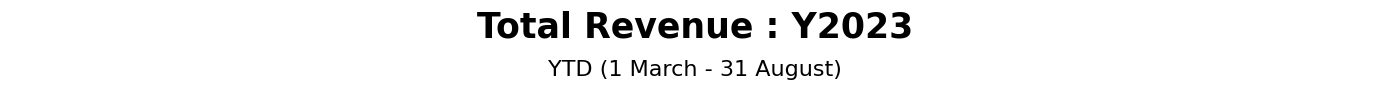

In [ ]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

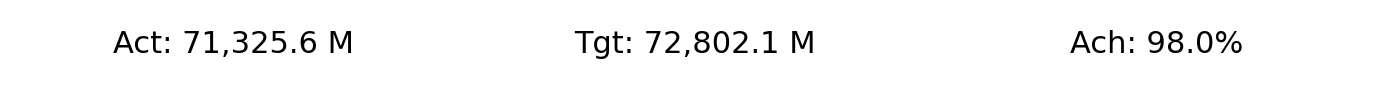

In [ ]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

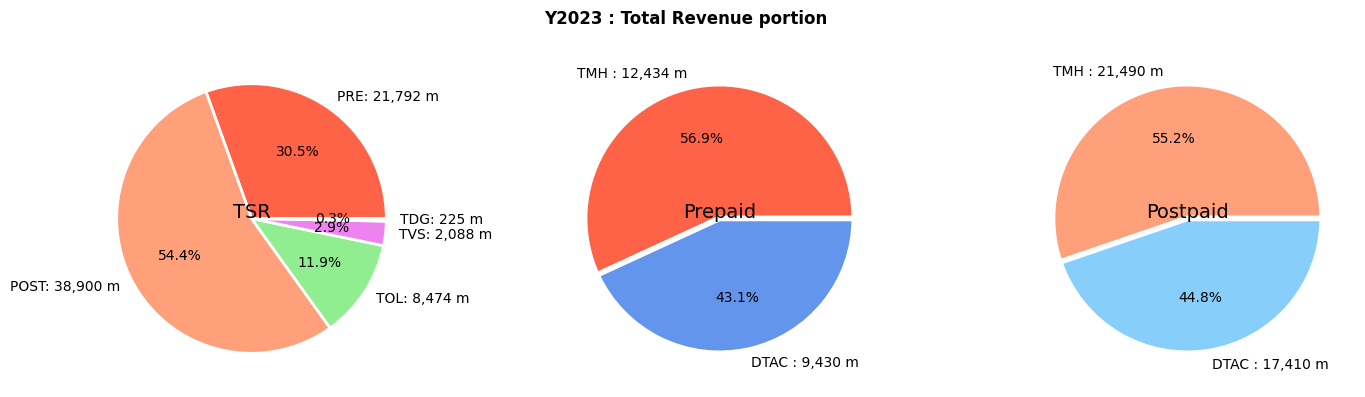

In [ ]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : Total Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum(), y_yr_act_tdg.sum()])
mylabels = [f"PRE: {format(y[0],',.0f')} m", f"POST: {format(y[1],',.0f')} m", f"TOL: {format(y[2],',.0f')} m", f"TVS: {format(y[3],',.0f')} m", f"TDG: {format(y[4],',.0f')} m"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'TSR', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [ ]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
48939,TNSC00143,TDG Revenue (Conso View),202304,April,N,227.642043,295.0,0.771668,-67.357957,237.292177,-9.650133,-0.040668
48974,TNSC00143,TDG Revenue (Conso View),202305,May,N,242.844352,278.0,0.873541,-35.155648,227.642043,15.202309,0.066782
49002,TNSC00143,TDG Revenue (Conso View),202306,June,N,248.485133,254.0,0.978288,-5.514867,242.844352,5.640781,0.023228
49037,TNSC00143,TDG Revenue (Conso View),202307,July,N,231.000000,258.0,0.895349,-27.000000,248.485133,-17.485133,-0.070367
49051,TNSC00143,TDG Revenue (Conso View),202308,August,N,225.000000,327.0,0.688073,-102.000000,231.000000,-6.000000,-0.025974


In [ ]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                            \
METRIC_NAME                             POST    POST_DTAC     POST_TMH   
3               202306     June  6444.851566  2945.530956  3499.320610   
4               202307     July  6451.450098  2940.214328  3511.235770   
5               202308   August  6163.427061  2626.846649  3536.580412   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH         TDG          TOL   
3            3638.806180  1562.505355  2076.300825  248.485133  1429.958869   
4            3793.031946  1619.285724  2173.746222  231.000000  1413.384874   
5            3372.756394  1447.978932  1996.919073  225.000000  1369.912535   

             ...        DIFF      %MOM                                \
METRIC_NAME  ...         TVS      POST POST_DTAC  POST_TMH       PRE   
3            ...   -5.314263 -0.020937 -0.002553 -0.035894 -0.024625   
4            ...   33.422513  0.001024 -0.001805  0.003405  0.042384   
5            ... -146.807988 -0.044645 -0.106580  0.007218 -0.110802   

                                                               
METRIC_NAME  PRE_DTAC   PRE_TMH       TDG       TOL       TVS  
3           -0.029669 -0.020795  0.023228  0.000853 -0.014734  
4            0.036339  0.046932 -0.070367 -0.011591  0.094050  
5           -0.105792 -0.081347 -0.025974 -0.030758 -0.377601  

[3 rows x 65 columns]

In [ ]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                            \
METRIC_NAME                             POST    POST_DTAC     POST_TMH   
3               202306     June  6444.851566  2945.530956  3499.320610   
4               202307     July  6451.450098  2940.214328  3511.235770   
5               202308   August  6163.427061  2626.846649  3536.580412   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH         TDG          TOL   
3            3638.806180  1562.505355  2076.300825  248.485133  1429.958869   
4            3793.031946  1619.285724  2173.746222  231.000000  1413.384874   
5            3372.756394  1447.978932  1996.919073  225.000000  1369.912535   

             ...      %MOM                            ACT_BG        TGT_BG  \
METRIC_NAME  ...       TDG       TOL       TVS                               
3            ...  0.023228  0.000853 -0.014734  11868.985678  12247.219233   
4            ... -0.070367 -0.011591  0.094050  12046.658495  12290.879756   
5            ... -0.025974 -0.030758 -0.377601  11220.221189  11541.245561   

             %ACHV_BG      GAP_BG   LAST_ACT_BG     DIFF_BG   %MOM_BG  
METRIC_NAME                                                            
3            0.969117 -378.233554  12102.767796 -233.782118 -0.019316  
4            0.980130 -244.221262  11868.985678  177.672816  0.014970  
5            0.972185 -321.024372  12046.658495 -826.437305 -0.068603  

[3 rows x 72 columns]

In [ ]:
''' BG Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# mtd_last_act_tmp = df_last_mth.head(day_cnt_curr_mth)['ACT_BG'].sum()
mtd_last_act = (df_last_mth['ACT_BG'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [ ]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_SNAP']['POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_SNAP']['POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_SNAP']['POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_SNAP']['PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_SNAP']['PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_SNAP']['PRE_TMH']
y_mth_act_tdg = df_rev_mth_agg['ACT_SNAP']['TDG']
y_mth_act_tol = df_rev_mth_agg['ACT_SNAP']['TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_SNAP']['TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_SNAP']['POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_SNAP']['POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_SNAP']['POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_SNAP']['PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_SNAP']['PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_SNAP']['PRE_TMH']
y_mth_tgt_tdg = df_rev_mth_agg['TGT_SNAP']['TDG']
y_mth_tgt_tol = df_rev_mth_agg['TGT_SNAP']['TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV']['POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV']['POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV']['POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV']['PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV']['PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV']['PRE_TMH']
y_mth_achv_tdg = df_rev_mth_agg['%ACHV']['TDG']
y_mth_achv_tol = df_rev_mth_agg['%ACHV']['TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV']['TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP']['POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP']['POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP']['POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP']['PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP']['PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP']['PRE_TMH']
y_mth_gap_tdg = df_rev_mth_agg['GAP']['TDG']
y_mth_gap_tol = df_rev_mth_agg['GAP']['TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP']['TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT']['POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT']['POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT']['POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT']['PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT']['PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT']['PRE_TMH']
y_mth_last_act_tdg = df_rev_mth_agg['LAST_ACT']['TDG']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT']['TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF']['POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF']['POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF']['POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF']['PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF']['PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF']['PRE_TMH']
y_mth_diff_tdg = df_rev_mth_agg['DIFF']['TDG']
y_mth_diff_tol = df_rev_mth_agg['DIFF']['TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF']['TVS']

''' % MOM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM']['POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM']['POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM']['POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM']['PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM']['PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM']['PRE_TMH']
y_mth_mom_tdg = df_rev_mth_agg['%MOM']['TDG']
y_mth_mom_tol = df_rev_mth_agg['%MOM']['TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM']['TVS']

### MTH : Visualizations

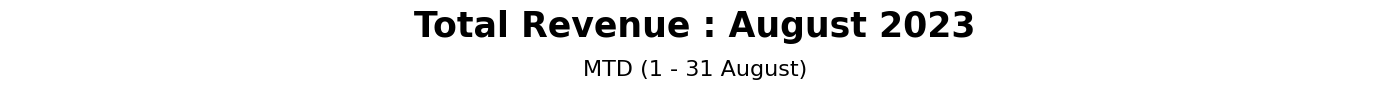

In [ ]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

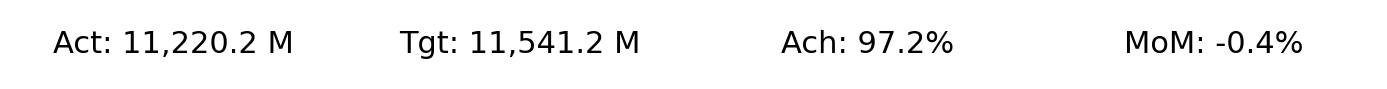

In [ ]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

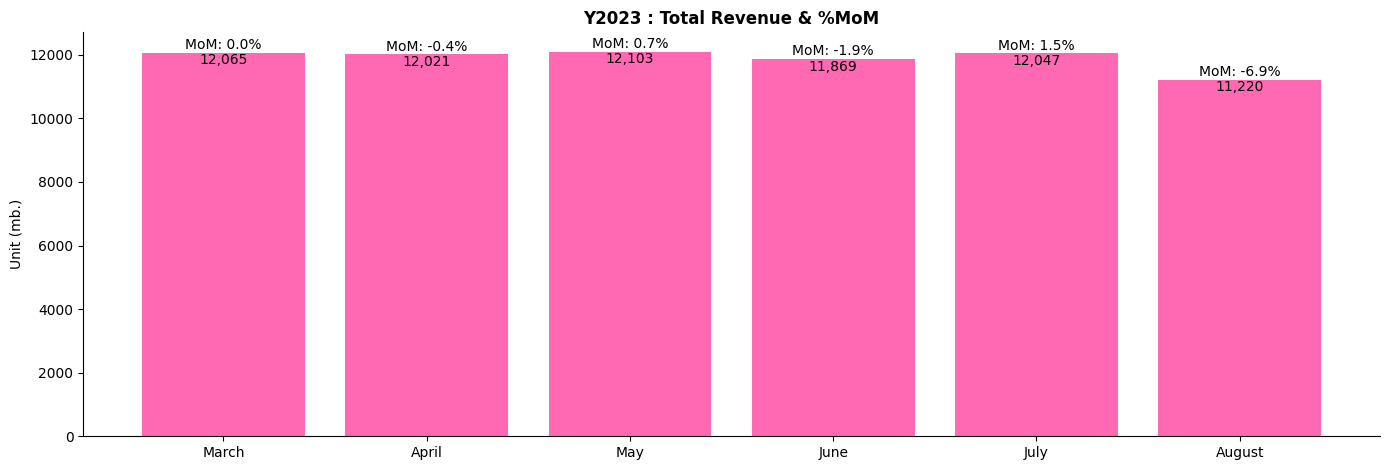

In [ ]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

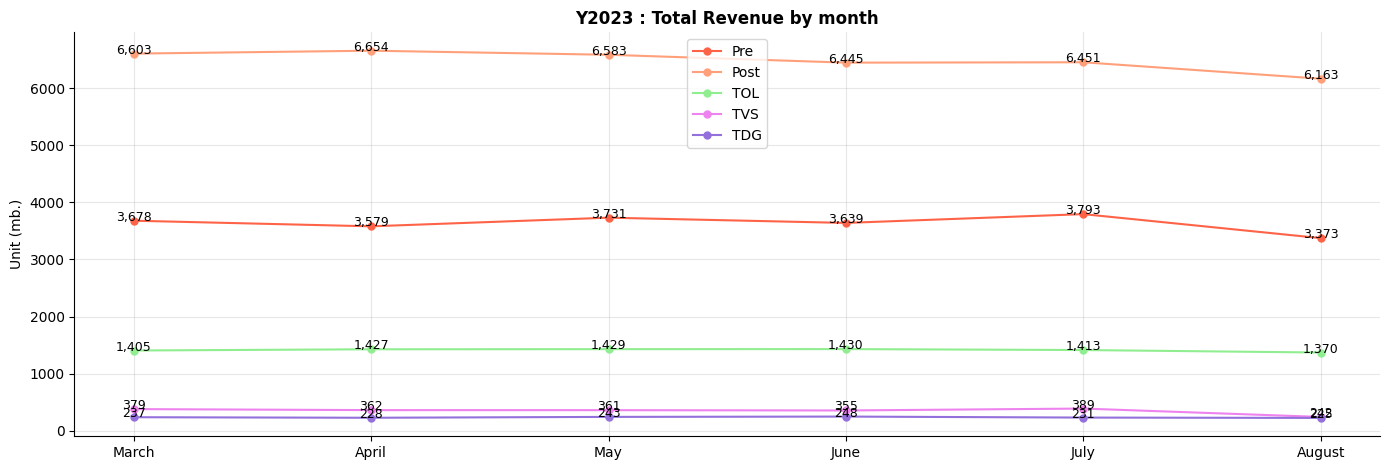

In [ ]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

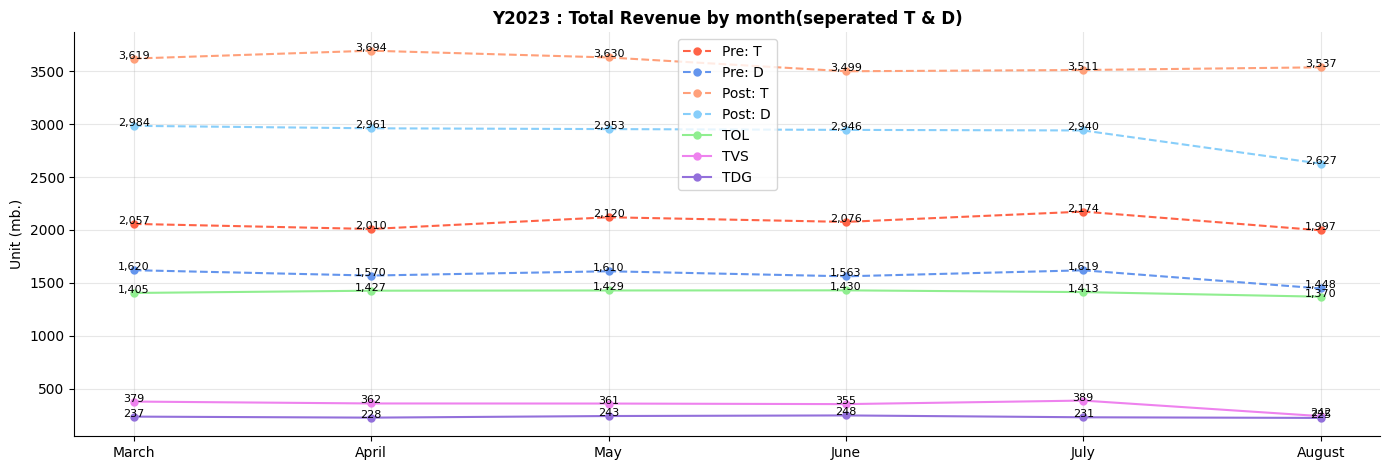

In [ ]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month(seperated T & D)", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [ ]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
49037,TNSC00143,TDG Revenue (Conso View),2023031,31,N,231.0,258.0,0.895349,-27.0,231.0,0.0,0.000000
49044,TNSC00143,TDG Revenue (Conso View),2023032,32,N,235.0,327.0,0.718654,-92.0,231.0,4.0,0.017316
49051,TNSC00143,TDG Revenue (Conso View),2023033,33,N,225.0,327.0,0.688073,-102.0,235.0,-10.0,-0.042553


In [ ]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                          \
METRIC_NAME                            POST   POST_DTAC    POST_TMH   
24            2023033       33  1335.466308  605.534776  729.931532   
25            2023034       34  1352.090140  633.156729  718.933411   
26            2023035       35   471.944526   96.079808  375.864717   

                                                                    ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH    TDG         TOL  ...   
24           817.207421  352.225499  464.981922  225.0  294.128049  ...   
25           817.403586  350.101609  467.301977    NaN  281.142665  ...   
26           126.731992   51.787215  147.086387    NaN  155.679705  ...   

                  DIFF      %WOW                                          \
METRIC_NAME        TVS      POST POST_DTAC  POST_TMH       PRE  PRE_DTAC   
24          -13.654562 -0.125001 -0.064721 -0.169410 -0.015583 -0.010240   
25           -3.443348  0.012448  0.045616 -0.015067  0.000240 -0.006030   
26          -53.727847 -0.650952 -0.848253 -0.477191 -0.844958 -0.852079   

                                                     
METRIC_NAME   PRE_TMH       TDG       TOL       TVS  
24          -0.019592 -0.042553 -0.177517 -0.192699  
25           0.004990       NaN -0.044149 -0.060193  
26          -0.685243       NaN -0.446261 -0.999372  

[3 rows x 65 columns]

In [ ]:
''' Add column for BG Summary '''

df_rev_wk_agg['ACT_BG'] = df_rev_wk_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['TGT_BG'] = df_rev_wk_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['%ACHV_BG'] = df_rev_wk_agg['ACT_BG'] / df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['GAP_BG'] = df_rev_wk_agg['ACT_BG'] - df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['LAST_ACT_BG'] = df_rev_wk_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['DIFF_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, df_rev_wk_agg['ACT_BG']-df_rev_wk_agg['LAST_ACT_BG'])
df_rev_wk_agg['%WOW_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, (df_rev_wk_agg['ACT_BG']/df_rev_wk_agg['LAST_ACT_BG'])-1)

df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                          \
METRIC_NAME                            POST   POST_DTAC    POST_TMH   
24            2023033       33  1335.466308  605.534776  729.931532   
25            2023034       34  1352.090140  633.156729  718.933411   
26            2023035       35   471.944526   96.079808  375.864717   

                                                                    ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH    TDG         TOL  ...   
24           817.207421  352.225499  464.981922  225.0  294.128049  ...   
25           817.403586  350.101609  467.301977    NaN  281.142665  ...   
26           126.731992   51.787215  147.086387    NaN  155.679705  ...   

                 %WOW                           ACT_BG       TGT_BG  %ACHV_BG  \
METRIC_NAME       TDG       TOL       TVS                                       
24          -0.042553 -0.177517 -0.192699  2504.006714  2607.255619  0.960399   
25                NaN -0.044149 -0.060193  2504.397980  2576.148224  0.972148   
26                NaN -0.446261 -0.999372   826.531574   859.411813  0.961741   

                 GAP_BG  LAST_ACT_BG      DIFF_BG   %WOW_BG  
METRIC_NAME                                                  
24          -103.248905  2784.861241  -280.854527 -0.100850  
25           -71.750245  2504.006714     0.391265  0.000156  
26           -32.880238  2504.397980 -1677.866405 -0.669968  

[3 rows x 72 columns]

In [ ]:
''' BG Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())

# wtd_last_act_tmp = df_last_wk.head(day_cnt_curr_wk)['ACT_BG'].sum()
wtd_last_act = (df_last_wk['ACT_BG'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [ ]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Actual '''
y_wk_act = df_rev_wk_agg['ACT_BG']
y_wk_act_post = df_rev_wk_agg['ACT_SNAP']['POST']
y_wk_act_post_dtac = df_rev_wk_agg['ACT_SNAP']['POST_DTAC']
y_wk_act_post_tmh = df_rev_wk_agg['ACT_SNAP']['POST_TMH']
y_wk_act_pre = df_rev_wk_agg['ACT_SNAP']['PRE']
y_wk_act_pre_dtac = df_rev_wk_agg['ACT_SNAP']['PRE_DTAC']
y_wk_act_pre_tmh = df_rev_wk_agg['ACT_SNAP']['PRE_TMH']
y_wk_act_tdg = df_rev_wk_agg['ACT_SNAP']['TDG']
y_wk_act_tol = df_rev_wk_agg['ACT_SNAP']['TOL']
y_wk_act_tvs = df_rev_wk_agg['ACT_SNAP']['TVS']

''' Target '''
y_wk_tgt = df_rev_wk_agg['TGT_BG']
y_wk_tgt_post = df_rev_wk_agg['TGT_SNAP']['POST']
y_wk_tgt_post_dtac = df_rev_wk_agg['TGT_SNAP']['POST_DTAC']
y_wk_tgt_post_tmh = df_rev_wk_agg['TGT_SNAP']['POST_TMH']
y_wk_tgt_pre = df_rev_wk_agg['TGT_SNAP']['PRE']
y_wk_tgt_pre_dtac = df_rev_wk_agg['TGT_SNAP']['PRE_DTAC']
y_wk_tgt_pre_tmh = df_rev_wk_agg['TGT_SNAP']['PRE_TMH']
y_wk_tgt_tdg = df_rev_wk_agg['TGT_SNAP']['TDG']
y_wk_tgt_tol = df_rev_wk_agg['TGT_SNAP']['TOL']
y_wk_tgt_tvs = df_rev_wk_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_wk_achv = df_rev_wk_agg['%ACHV_BG']
y_wk_achv_post = df_rev_wk_agg['%ACHV']['POST']
y_wk_achv_post_dtac = df_rev_wk_agg['%ACHV']['POST_DTAC']
y_wk_achv_post_tmh = df_rev_wk_agg['%ACHV']['POST_TMH']
y_wk_achv_pre = df_rev_wk_agg['%ACHV']['PRE']
y_wk_achv_pre_dtac = df_rev_wk_agg['%ACHV']['PRE_DTAC']
y_wk_achv_pre_tmh = df_rev_wk_agg['%ACHV']['PRE_TMH']
y_wk_achv_tdg = df_rev_wk_agg['%ACHV']['TDG']
y_wk_achv_tol = df_rev_wk_agg['%ACHV']['TOL']
y_wk_achv_tvs = df_rev_wk_agg['%ACHV']['TVS']

''' Gap '''
y_wk_gap = df_rev_wk_agg['GAP_BG']
y_wk_gap_post = df_rev_wk_agg['GAP']['POST']
y_wk_gap_post_dtac = df_rev_wk_agg['GAP']['POST_DTAC']
y_wk_gap_post_tmh = df_rev_wk_agg['GAP']['POST_TMH']
y_wk_gap_pre = df_rev_wk_agg['GAP']['PRE']
y_wk_gap_pre_dtac = df_rev_wk_agg['GAP']['PRE_DTAC']
y_wk_gap_pre_tmh = df_rev_wk_agg['GAP']['PRE_TMH']
y_wk_gap_tdg = df_rev_wk_agg['GAP']['TDG']
y_wk_gap_tol = df_rev_wk_agg['GAP']['TOL']
y_wk_gap_tvs = df_rev_wk_agg['GAP']['TVS']

''' Last Actual '''
y_wk_last_act = df_rev_wk_agg['LAST_ACT_BG']
y_wk_last_act_post = df_rev_wk_agg['LAST_ACT']['POST']
y_wk_last_act_post_dtac = df_rev_wk_agg['LAST_ACT']['POST_DTAC']
y_wk_last_act_post_tmh = df_rev_wk_agg['LAST_ACT']['POST_TMH']
y_wk_last_act_pre = df_rev_wk_agg['LAST_ACT']['PRE']
y_wk_last_act_pre_dtac = df_rev_wk_agg['LAST_ACT']['PRE_DTAC']
y_wk_last_act_pre_tmh = df_rev_wk_agg['LAST_ACT']['PRE_TMH']
y_wk_last_act_tdg = df_rev_wk_agg['LAST_ACT']['TDG']
y_wk_last_act_tol = df_rev_wk_agg['LAST_ACT']['TOL']
y_wk_last_act_tvs = df_rev_wk_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_wk_diff = df_rev_wk_agg['DIFF_BG']
y_wk_diff_post = df_rev_wk_agg['DIFF']['POST']
y_wk_diff_post_dtac = df_rev_wk_agg['DIFF']['POST_DTAC']
y_wk_diff_post_tmh = df_rev_wk_agg['DIFF']['POST_TMH']
y_wk_diff_pre = df_rev_wk_agg['DIFF']['PRE']
y_wk_diff_pre_dtac = df_rev_wk_agg['DIFF']['PRE_DTAC']
y_wk_diff_pre_tmh = df_rev_wk_agg['DIFF']['PRE_TMH']
y_wk_diff_tdg = df_rev_wk_agg['DIFF']['TDG']
y_wk_diff_tol = df_rev_wk_agg['DIFF']['TOL']
y_wk_diff_tvs = df_rev_wk_agg['DIFF']['TVS']

''' % WOW '''
y_wk_wow = df_rev_wk_agg['%WOW_BG']
y_wk_wow_post = df_rev_wk_agg['%WOW']['POST']
y_wk_wow_post_dtac = df_rev_wk_agg['%WOW']['POST_DTAC']
y_wk_wow_post_tmh = df_rev_wk_agg['%WOW']['POST_TMH']
y_wk_wow_pre = df_rev_wk_agg['%WOW']['PRE']
y_wk_wow_pre_dtac = df_rev_wk_agg['%WOW']['PRE_DTAC']
y_wk_wow_pre_tmh = df_rev_wk_agg['%WOW']['PRE_TMH']
y_wk_wow_tdg = df_rev_wk_agg['%WOW']['TDG']
y_wk_wow_tol = df_rev_wk_agg['%WOW']['TOL']
y_wk_wow_tvs = df_rev_wk_agg['%WOW']['TVS']

### WK : Visualizations

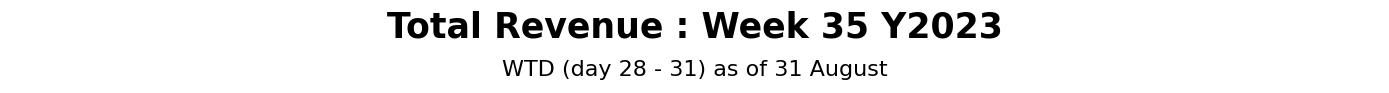

In [ ]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

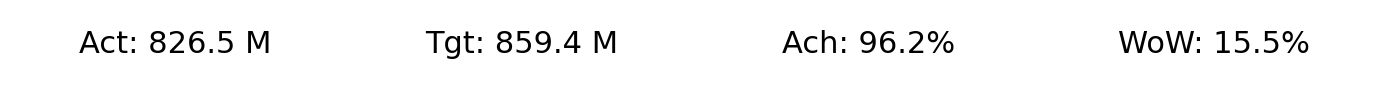

In [ ]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

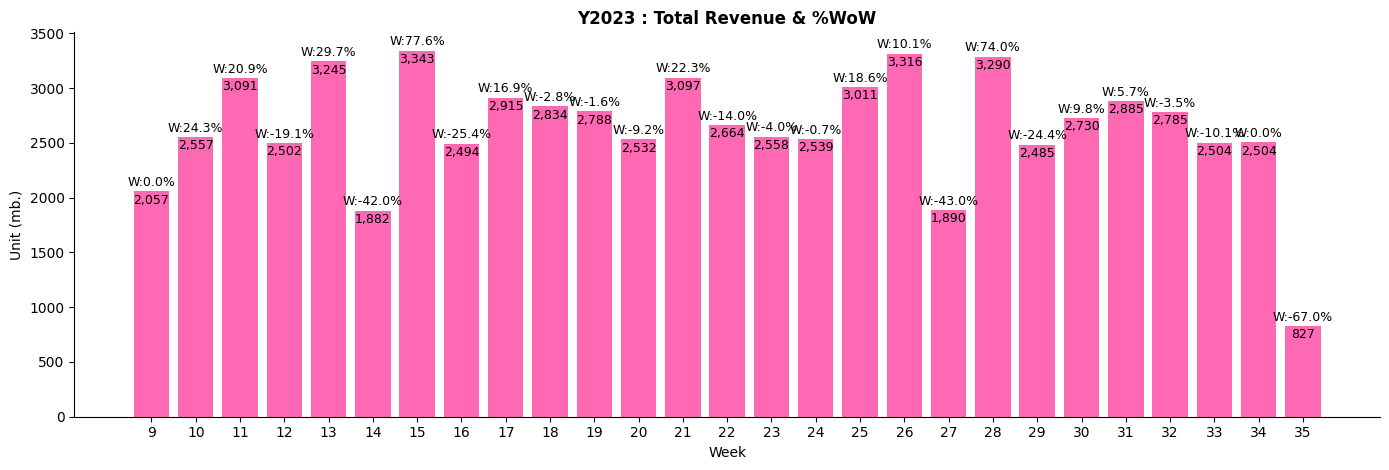

In [ ]:
''' Total Revenue & WoW : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %WoW", weight='bold')
plt.bar(x_wk_axis, y_wk_act, label='Total', color='hotpink')
for i in x_wk_axis:
    plt.annotate(f"W:{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.tight_layout()
plt.show()

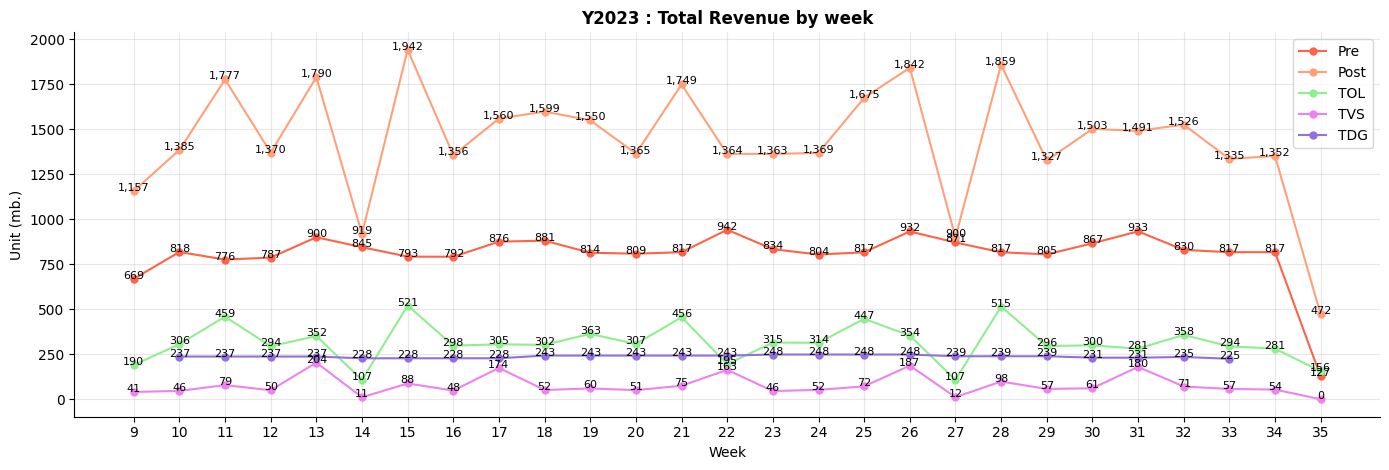

In [ ]:
''' Revenue : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_wk_axis, y_wk_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

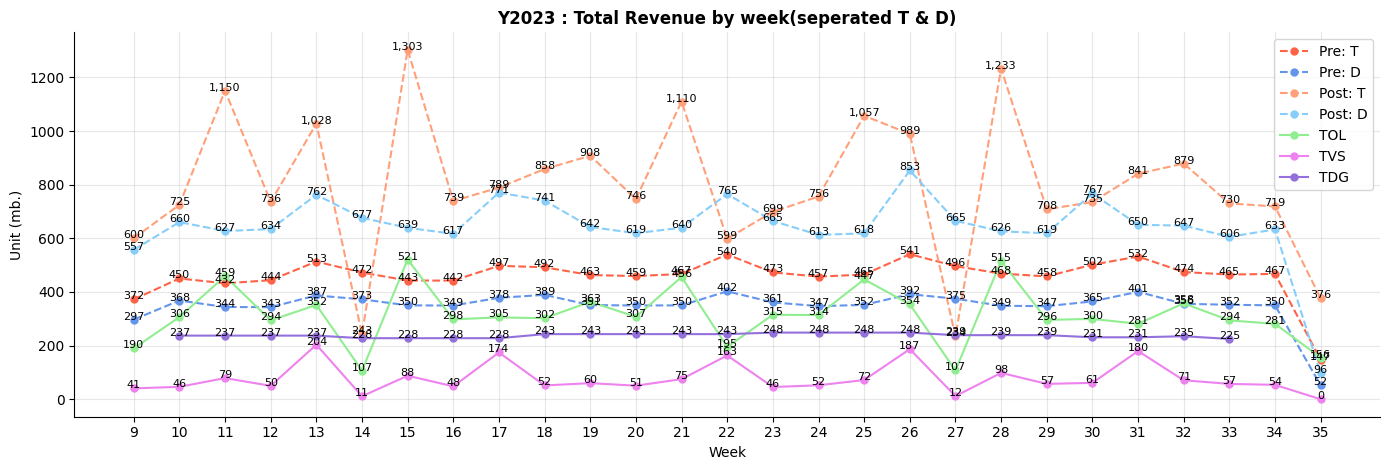

In [ ]:
''' Revenue(Mobile separated by TMH, DTAC) : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week(seperated T & D)", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_wk_axis, y_wk_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_wk_axis, y_wk_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_pre_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [ ]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT_BG'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [ ]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT_BG'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT_BG'].sum()
dtd_tgt = df_rev_day_curr_day['TGT_BG'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT_BG'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

In [ ]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Actual '''
y_day_act = df_rev_day_curr_mth['ACT_BG']
y_day_act_post = df_rev_day_curr_mth['ACT_SNAP']['POST']
y_day_act_post_dtac = df_rev_day_curr_mth['ACT_SNAP']['POST_DTAC']
y_day_act_post_tmh = df_rev_day_curr_mth['ACT_SNAP']['POST_TMH']
y_day_act_pre = df_rev_day_curr_mth['ACT_SNAP']['PRE']
y_day_act_pre_dtac = df_rev_day_curr_mth['ACT_SNAP']['PRE_DTAC']
y_day_act_pre_tmh = df_rev_day_curr_mth['ACT_SNAP']['PRE_TMH']
y_day_act_tdg = df_rev_day_curr_mth['ACT_SNAP']['TDG']
y_day_act_tol = df_rev_day_curr_mth['ACT_SNAP']['TOL']
y_day_act_tvs = df_rev_day_curr_mth['ACT_SNAP']['TVS']

''' Target '''
y_day_tgt = df_rev_day_curr_mth['TGT_BG']
y_day_tgt_post = df_rev_day_curr_mth['TGT_SNAP']['POST']
y_day_tgt_post_dtac = df_rev_day_curr_mth['TGT_SNAP']['POST_DTAC']
y_day_tgt_post_tmh = df_rev_day_curr_mth['TGT_SNAP']['POST_TMH']
y_day_tgt_pre = df_rev_day_curr_mth['TGT_SNAP']['PRE']
y_day_tgt_pre_dtac = df_rev_day_curr_mth['TGT_SNAP']['PRE_DTAC']
y_day_tgt_pre_tmh = df_rev_day_curr_mth['TGT_SNAP']['PRE_TMH']
y_day_tgt_tdg = df_rev_day_curr_mth['TGT_SNAP']['TDG']
y_day_tgt_tol = df_rev_day_curr_mth['TGT_SNAP']['TOL']
y_day_tgt_tvs = df_rev_day_curr_mth['TGT_SNAP']['TVS']

''' % Achievement '''
y_day_achv = df_rev_day_curr_mth['%ACHV_BG']
y_day_achv_post = df_rev_day_curr_mth['%ACHV']['POST']
y_day_achv_post_dtac = df_rev_day_curr_mth['%ACHV']['POST_DTAC']
y_day_achv_post_tmh = df_rev_day_curr_mth['%ACHV']['POST_TMH']
y_day_achv_pre = df_rev_day_curr_mth['%ACHV']['PRE']
y_day_achv_pre_dtac = df_rev_day_curr_mth['%ACHV']['PRE_DTAC']
y_day_achv_pre_tmh = df_rev_day_curr_mth['%ACHV']['PRE_TMH']
y_day_achv_tdg = df_rev_day_curr_mth['%ACHV']['TDG']
y_day_achv_tol = df_rev_day_curr_mth['%ACHV']['TOL']
y_day_achv_tvs = df_rev_day_curr_mth['%ACHV']['TVS']

''' Gap '''
y_day_gap = df_rev_day_curr_mth['GAP_BG']
y_day_gap_post = df_rev_day_curr_mth['GAP']['POST']
y_day_gap_post_dtac = df_rev_day_curr_mth['GAP']['POST_DTAC']
y_day_gap_post_tmh = df_rev_day_curr_mth['GAP']['POST_TMH']
y_day_gap_pre = df_rev_day_curr_mth['GAP']['PRE']
y_day_gap_pre_dtac = df_rev_day_curr_mth['GAP']['PRE_DTAC']
y_day_gap_pre_tmh = df_rev_day_curr_mth['GAP']['PRE_TMH']
y_day_gap_tdg = df_rev_day_curr_mth['GAP']['TDG']
y_day_gap_tol = df_rev_day_curr_mth['GAP']['TOL']
y_day_gap_tvs = df_rev_day_curr_mth['GAP']['TVS']

''' Last Actual '''
y_day_last_act = df_rev_day_curr_mth['LAST_ACT_BG']
y_day_last_act_post = df_rev_day_curr_mth['LAST_ACT']['POST']
y_day_last_act_post_dtac = df_rev_day_curr_mth['LAST_ACT']['POST_DTAC']
y_day_last_act_post_tmh = df_rev_day_curr_mth['LAST_ACT']['POST_TMH']
y_day_last_act_pre = df_rev_day_curr_mth['LAST_ACT']['PRE']
y_day_last_act_pre_dtac = df_rev_day_curr_mth['LAST_ACT']['PRE_DTAC']
y_day_last_act_pre_tmh = df_rev_day_curr_mth['LAST_ACT']['PRE_TMH']
y_day_last_act_tdg = df_rev_day_curr_mth['LAST_ACT']['TDG']
y_day_last_act_tol = df_rev_day_curr_mth['LAST_ACT']['TOL']
y_day_last_act_tvs = df_rev_day_curr_mth['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_day_diff = df_rev_day_curr_mth['DIFF_BG']
y_day_diff_post = df_rev_day_curr_mth['DIFF']['POST']
y_day_diff_post_dtac = df_rev_day_curr_mth['DIFF']['POST_DTAC']
y_day_diff_post_tmh = df_rev_day_curr_mth['DIFF']['POST_TMH']
y_day_diff_pre = df_rev_day_curr_mth['DIFF']['PRE']
y_day_diff_pre_dtac = df_rev_day_curr_mth['DIFF']['PRE_DTAC']
y_day_diff_pre_tmh = df_rev_day_curr_mth['DIFF']['PRE_TMH']
y_day_diff_tdg = df_rev_day_curr_mth['DIFF']['TDG']
y_day_diff_tol = df_rev_day_curr_mth['DIFF']['TOL']
y_day_diff_tvs = df_rev_day_curr_mth['DIFF']['TVS']

''' % DOD '''
y_day_dod = df_rev_day_curr_mth['%DOD_BG']
y_day_dod_post = df_rev_day_curr_mth['%DOD']['POST']
y_day_dod_post_dtac = df_rev_day_curr_mth['%DOD']['POST_DTAC']
y_day_dod_post_tmh = df_rev_day_curr_mth['%DOD']['POST_TMH']
y_day_dod_pre = df_rev_day_curr_mth['%DOD']['PRE']
y_day_dod_pre_dtac = df_rev_day_curr_mth['%DOD']['PRE_DTAC']
y_day_dod_pre_tmh = df_rev_day_curr_mth['%DOD']['PRE_TMH']
y_day_dod_tdg = df_rev_day_curr_mth['%DOD']['TDG']
y_day_dod_tol = df_rev_day_curr_mth['%DOD']['TOL']
y_day_dod_tvs = df_rev_day_curr_mth['%DOD']['TVS']

### DAY : Visualizations

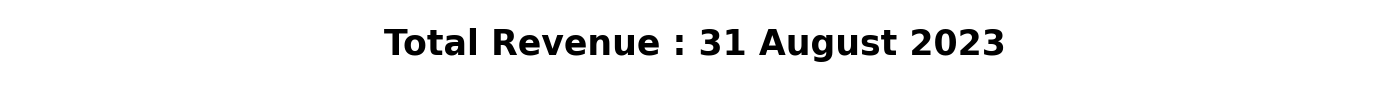

In [ ]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

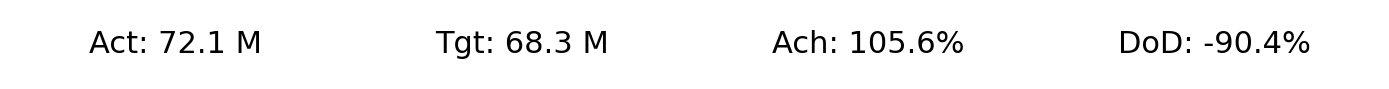

In [ ]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(dtd_rev,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(dtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

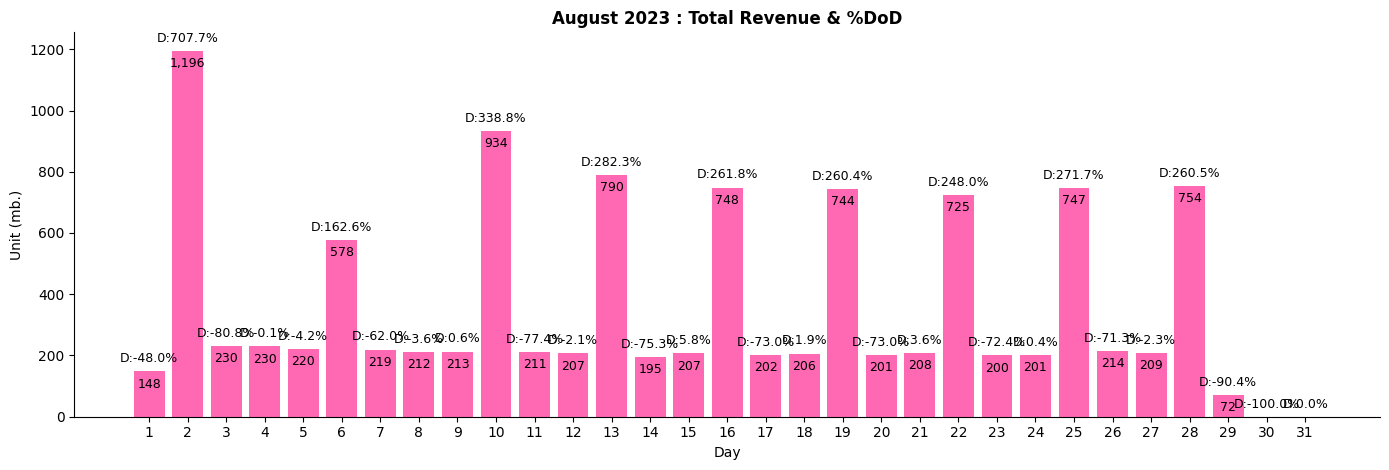

In [ ]:
''' Total Revenue & DoD : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue & %DoD", fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='hotpink')
for i in x_day_axis:
    plt.annotate(f"D:{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.tight_layout()
plt.show()

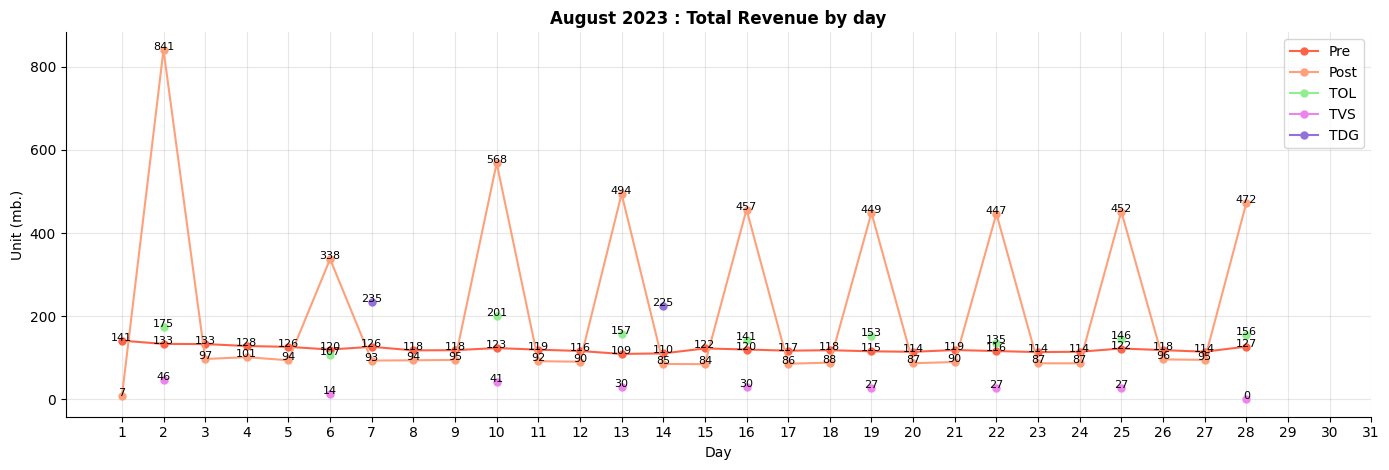

In [ ]:
''' Revenue : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_day_axis, y_day_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post[i],',.0f'), xy=(x_day_axis[i], y_day_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

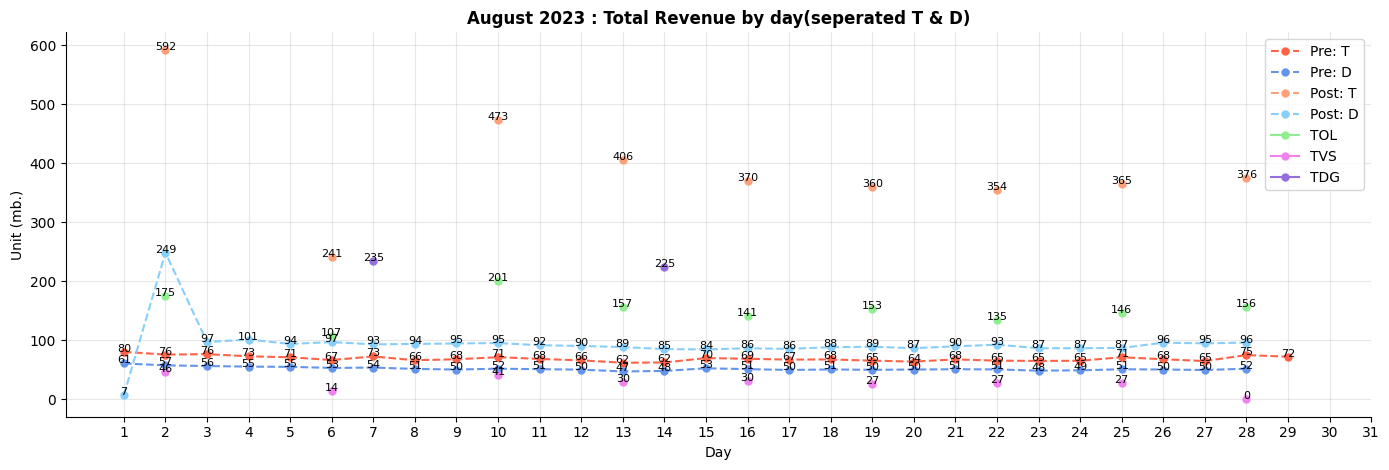

In [ ]:
''' Revenue(Mobile separated by TMH, DTAC) : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day(seperated T & D)", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_day_axis, y_day_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_day_axis, y_day_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_pre_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Generate Output Data

In [ ]:
# df_rev_day.to_excel('../data/interim/df_rev_day.xlsx', index=False)
# df_rev_yr.to_excel('../data/interim/df_rev_yr.xlsx', index=False)
# df_rev_mth.to_excel('../data/interim/df_rev_mth.xlsx', index=False)
# df_rev_wk.to_excel('../data/interim/df_rev_wk.xlsx', index=False)